<a href="https://colab.research.google.com/github/macsakini/Financial-Modelling/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is a Keras Implementation of the VIT**

In [4]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [5]:
#import de[endancies]
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [63]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train_1, y_train_1), (x_test_1, y_test_1) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train_1.shape} - y_train shape: {y_train_1.shape}")
print(f"x_test shape: {x_test_1.shape} - y_test shape: {y_test_1.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


# **We all know that the CIFAR Images are quite huge as such dimensionality rduction using a PCA Algorithm can help fine tune the model**

In [64]:
#Set learning parameters to that of the Keras Implementation
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

# **Classic Patching Implementation**

In [65]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


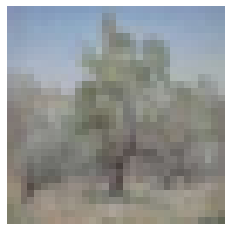

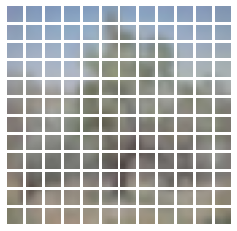

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train_1[np.random.choice(range(x_train_1.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

# ***The PCA Algorithm Implementation ***

**Implementation is derived from this paper
https://arxiv.org/ftp/arxiv/papers/1304/1304.2683.pdf**

In [12]:
#Import all necessary dependancies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

In [38]:
dataset = keras.datasets.cifar100.load_data()

(X,Y),(x,y) = dataset

In [39]:
X.shape 

(50000, 32, 32, 3)

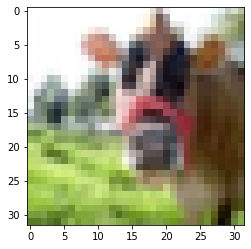

In [40]:
plt.imshow(X[0])

In [67]:
X_flat = np.array(X).reshape((50000, 32*32*3))

X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)

(35000, 3072)
(15000, 3072)


In [43]:
pca_dims = PCA()
pca_dims.fit(X_train)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [44]:
d

202

In [45]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [46]:
print("reduced shape: " + str(X_reduced.shape))
print("recovered shape: " + str(X_recovered.shape))

reduced shape: (35000, 202)
recovered shape: (35000, 3072)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


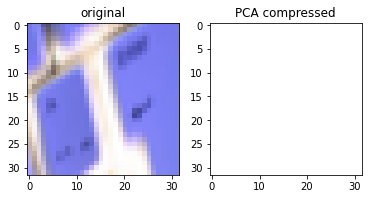

In [53]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_train[0].reshape((32,32,3)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_recovered[0].reshape((32,32,3)))
plt.show(block=True)

In [35]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [36]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [54]:

test_img=X_recovered[0].reshape((32,32,3))

# Augment data.
augmented = data_augmentation(test_img)
    # Create patches.
patches = Patches(patch_size)(augmented)
    # Encode patches.
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)


In [59]:
print(encoded_patches)

tf.Tensor(
[[[-0.18724051 -0.69447476 -0.05322197 ...  0.7903863   0.6240824
   -0.60837424]
  [-0.12412484 -0.8086192  -0.18669103 ...  0.78336203  0.69633204
   -0.66260433]
  [-0.15914248 -0.8267771  -0.2489398  ...  0.86067164  0.5428806
   -0.71714526]
  ...
  [-0.09538515 -0.414052    0.02060378 ...  0.63496774  0.42064783
   -0.41829208]
  [ 0.11108314 -0.37539962 -0.15650079 ...  0.7806062   0.58078766
   -0.46516955]
  [ 0.36914378 -0.49942663 -0.6723222  ...  1.2415265   0.7840929
   -0.66849   ]]], shape=(1, 144, 64), dtype=float32)


In [69]:
X_train = X_recovered.reshape(35000,32,32,3)

X_test_reduced = pca.fit_transform(X_test)
X_test_recovered = pca.inverse_transform(X_test_reduced)

In [71]:
X_test = X_test_recovered.reshape(15000,32,32,3)

In [56]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [57]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
  1/124 [..............................] - ETA: 1:18:04 - loss: 7.7224 - accuracy: 0.0078 - top-5-accuracy: 0.0586